# Glider data


In [11]:
% glider_data = readtable('glider_data.txt');
addpath ../data/
glider_data = readtable('Cleaned_Combined_Data.csv');

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


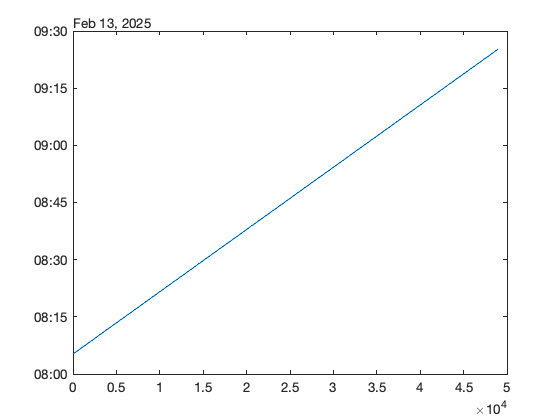

In [12]:
plot(glider_data.Timestamp)

## Glider table example

In [13]:
glider_data(1:5, :)


ans =

  5x14 table

           Timestamp           Quad_0_    Quad_1_    Quad_2_     Quad_3_     PQR_0_      PQR_1_     PQR_2_     ACC_0_     ACC_1_     ACC_2_     Euler_0_    Euler_1_    Euler_2_
    _______________________    _______    _______    ________    _______    ________    ________    _______    _______    ______    ________    ________    ________    ________

    2025-02-13 08:05:15.101    0.42353    0.17676    -0.06036    0.88642    -0.08178    -0.04085    0.04337    -3.1158    8.9454     -0.2185     2.4551     -21.303      128.51 
    2025-02-13 08:05:15.171    0.42275    0.17345    -0.06288    0.88727    -0.07495    -0.04282    0.03635    -3.1595    8.9004    -0.23389     2.0133     -21.094      128.71 
    2025-02-13 08:05:15.269    0.42217    0.17087    -0.06451    0.88793     -0.0563    -0.03247    0.03191    -3.1804    8.9089    -0.27861     1.7447     -20.911      128.85 
    2025-02-13 08:05:15.369    0.42192    0.16879    -0.06493    0.88841    -0.02906    -0.0

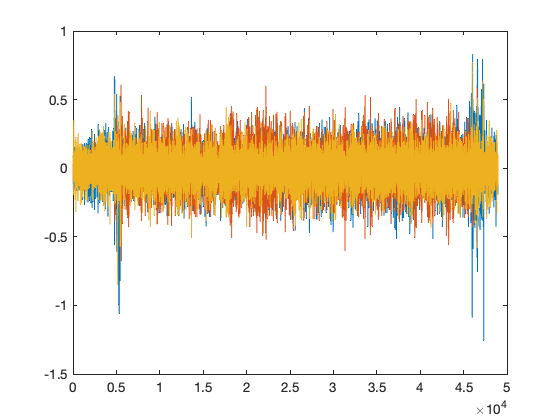

In [14]:
plot(glider_data.PQR_0_); hold on
plot(glider_data.PQR_1_);
plot(glider_data.PQR_2_);

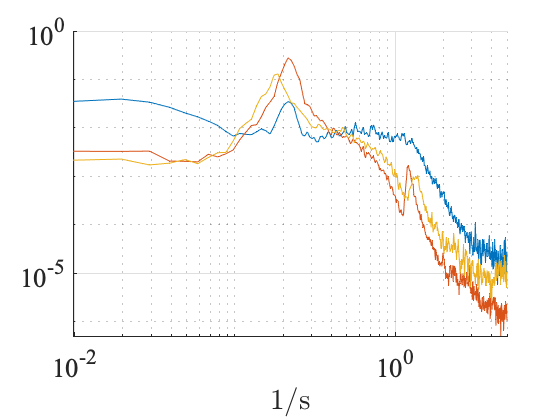

In [15]:

figure('position', [10 10 700 300])
[P,k]=fast_psd(glider_data.PQR_0_,2^10,10);
[P2,k]=fast_psd(glider_data.PQR_1_,2^10,10);
[P3,k]=fast_psd(glider_data.PQR_2_,2^10,10);

loglog(k,P); hold on
loglog(k,P2);
loglog(k,P3)

grid on
% ginput(3)

xlabel('1/s')
pretty_font

% export_fig first_test.pdf


Here we prepare the data to make sure the glider is vertical

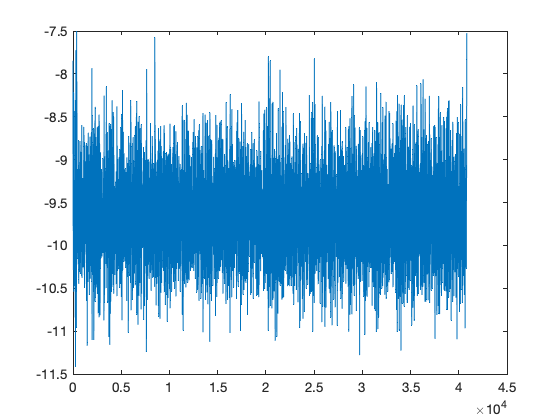

In [16]:
ac = glider_data.ACC_0_ < -7.5;
data = glider_data.ACC_0_(ac);

plot(data); hold on

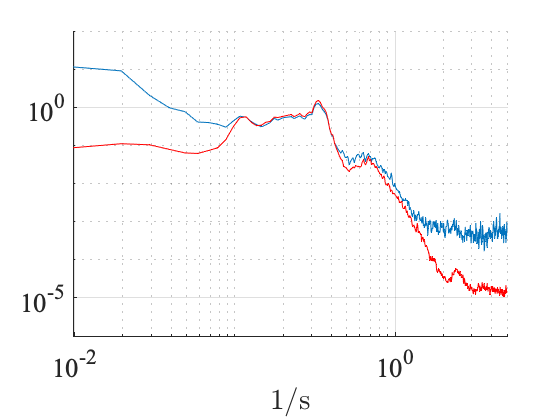

In [17]:

figure('position', [10 10 700 300])
[P,k]=fast_psd(glider_data.ACC_0_,2^10,10);
[Pi,k]=fast_psd(data,2^10,10);
% [P2,k]=fast_psd(glider_data.Var10,2^10,10);
% [P3,k]=fast_psd(glider_data.Var11,2^10,10);

loglog(k,P); hold on
loglog(k,Pi, 'r');
% loglog(k,P2);
% loglog(k,P3)

grid on
% ginput(3)

xlabel('1/s')
pretty_font

% export_fig first_test.pdf


## Creating filters and data prep


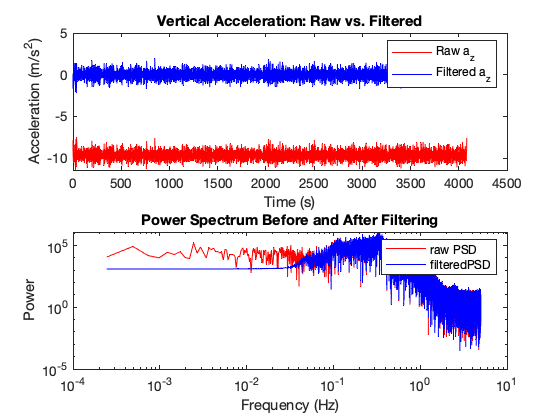

In [18]:
% Load or define your vertical acceleration data (a_z)
fs = 10; % Sampling frequency in Hz (adjust if needed)
fc = 0.05; % Cutoff frequency in Hz (remove drift below this)

% Design a 4th-order Butterworth high-pass filter
order = 4;  
Wn = fc / (fs/2); % Normalize frequency
[b, a] = butter(order, Wn, 'high');

% Apply the filter to the vertical acceleration data
a_z_filtered = filtfilt(b, a, data); % Assuming glider_data.Var9 is your vertical acceleration data
a_z = data; % Original vertical acceleration data
% Plot the original and filtered data
% Plot before and after filtering
t = (0:length(a_z)-1) / fs; % Time vector

figure;
subplot(2,1,1)
plot(t, a_z, 'r'); hold on;
plot(t, a_z_filtered, 'b');
legend('Raw a_z', 'Filtered a_z');
xlabel('Time (s)');
ylabel('Acceleration (m/s^2)');
title('Vertical Acceleration: Raw vs. Filtered');

subplot(2,1,2)
psd_raw = abs(fft(a_z)).^2; 
psd_filtered = abs(fft(a_z_filtered)).^2; 
f = linspace(0, fs/2, length(psd_raw)/2);

loglog(f, psd_raw(1:end/2), 'r'); hold on;
loglog(f, psd_filtered(1:end/2), 'b'); hold on


legend( 'raw PSD', 'filteredPSD');
xlabel('Frequency (Hz)');
ylabel('Power');
title('Power Spectrum Before and After Filtering');



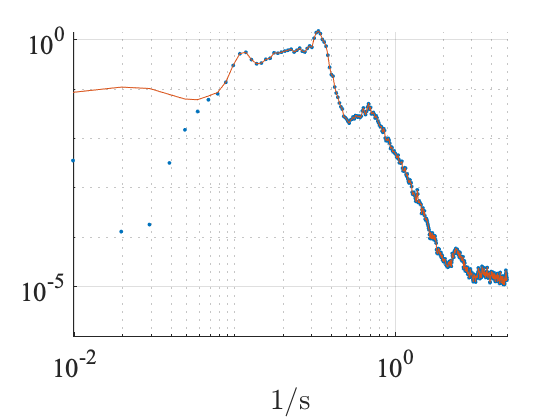

In [19]:

figure('position', [10 10 700 300])
[P,k]=fast_psd(a_z_filtered,2^10,10);
[P2,k]=fast_psd(data,2^10,10);
% [P2,k]=fast_psd(glider_data.Var10,2^10,10);
% [P3,k]=fast_psd(glider_data.Var11,2^10,10);

loglog(k,P, '.'); hold on
 loglog(k,P2);
% loglog(k,P3)


grid on
% ginput(3)

xlabel('1/s')
pretty_font


In [20]:
% edit fast_psd.m

In [21]:
whos  S_eta P_eta P S_a_z k f 

  Name        Size                Bytes  Class     Attributes

  P         512x1                  4096  double              
  f           1x20414            163312  double              
  k         512x1                  4096  double              



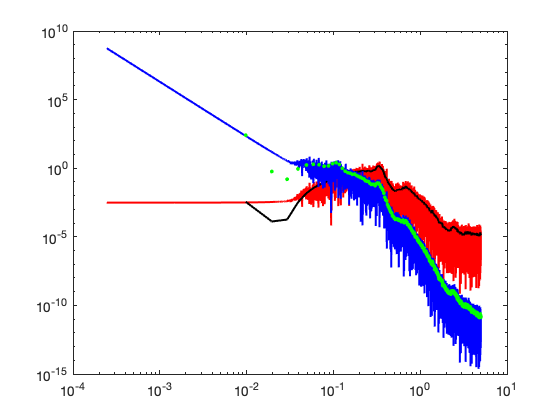

In [22]:
% Given parameters
fs = 10; % Sampling frequency in Hz (adjust as needed)
N = length(a_z_filtered); % Number of data points
dt = 1/fs; % Time step
f = (0:N/2-1) * (fs/N); % Frequency vector (one-sided)

% % Compute acceleration power spectral density (PSD)
A_z = fft(a_z_filtered); % Compute FFT
S_a_z = (abs(A_z).^2) / (N * fs); % Compute PSD (single-sided)
S_a_z = S_a_z(1:N/2); % Keep only positive frequencies


[P,k]=fast_psd(a_z_filtered,2^10,10);

% % Convert acceleration PSD to displacement PSD
S_eta = S_a_z ./ ( (2 * pi * f').^4 ); 
P_eta = P ./ ( (2 * pi * k).^4 ); 

% % Handle f = 0 case to avoid division by zero
P_eta(k == 0) = 0; 

% % Plot results
% figure;

loglog(f, S_a_z, 'r', 'LineWidth', 1.5); hold on;
loglog(k, P, 'k', 'LineWidth', 1.5); hold on;

loglog(f, S_eta, 'b', 'LineWidth', 1.5);
loglog(k, P_eta, 'g.', 'LineWidth', 1.5);
% legend('Acceleration PSD', 'Displacement PSD');
% xlabel('Frequency (Hz)');
% ylabel('Power Spectral Density');
% title('Conversion from Acceleration to Displacement Spectrum');
% grid on;
line(.05, ylim);

In [23]:
edit fast_psd.m

In [24]:
% Step 1: Calculate m0 (zero-th moment of the displacement spectrum)
% m0 = trapz(f, S_eta);  % Numerical integration of S_eta over frequency
m0_p = trapz(k, P_eta);  % Numerical integration of S_eta over frequency

% Step 2: Calculate Significant Wave Height (H_s)
% H_s = 4 * sqrt(m0);
H_sp = 4 * sqrt(m0_p);

% Display result

disp(['Significant Wave Height Hs: ', num2str(H_sp), ' meters']);

Significant Wave Height Hs: 4.8231 meters


In [25]:
% Step 1: Find the dominant frequency (frequency with maximum displacement spectrum)
% [~, idx_peak] = max(P_eta)  % Find index of maximum displacement spectrum

% Here we need to figure out better what our boudnaries would look like,
f_min = 0.05; % Minimum frequency to consider
f_max = 10.0; % Maximum frequency to consider
idx = find(k >= f_min & k <= f_max);

[~, peak_idx] = max(P_eta(idx)); % Find max only in this range

% Find the peak frequency and period
f_peak = k(idx(peak_idx)); % Peak frequency
T_peak = 1 / f_peak;  % Peak period


% Display results
disp(['Dominant Frequency: ', num2str(f_peak), ' Hz']);
disp(['Peak Period: ', num2str(T_peak), ' seconds']);

Dominant Frequency: 0.10742 Hz
Peak Period: 9.3091 seconds


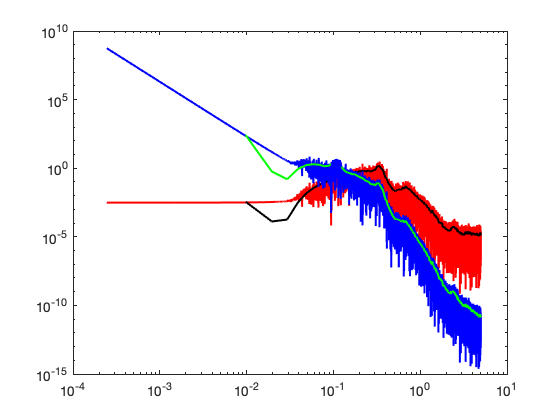

In [26]:
% % Plot results
% figure;

loglog(f, S_a_z, 'r', 'LineWidth', 1.5); hold on;
loglog(k, P, 'k', 'LineWidth', 1.5); hold on;

loglog(f, S_eta, 'b', 'LineWidth', 1.5);
loglog(k, P_eta, 'g', 'LineWidth', 1.5);

line(f_peak, P_eta(peak_idx), 'Marker', 'o', 'Color', 'b', 'MarkerSize', 8, 'MarkerFaceColor', 'b');

In [27]:
% Step 1: Find the dominant frequency (peak frequency)
[~, idx_peak] = max(P_eta);  % Find index of maximum displacement spectrum
f_peak = k(peak_idx);  % Dominant frequency

% % Step 2: Define a frequency range around the peak (e.g., ±20% of the peak frequency)
freq_range = [f_peak * 0.8, f_peak * 1.2]  % Range around the peak frequency

% % Step 3: Find indices for the frequency range
freq_indices = find(k >= freq_range(1) & k <= freq_range(2));

% % Step 4: Integrate over the selected frequency range (S_eta over the range)
m0 = trapz(k(freq_indices), P_eta(freq_indices));  % Numerical integration over the selected range

% % Step 5: Calculate Significant Wave Height (H_s)
 H_s = 4 * sqrt(m0);

% % Display result
disp(['Significant Wave Height Hs: ', num2str(H_s), ' meters']);



freq_range =

    0.0469    0.0703

Significant Wave Height Hs: 0.75837 meters


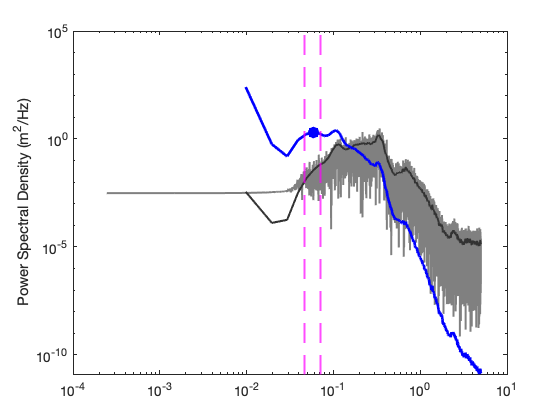

In [28]:
% % Plot results
% figure;

loglog(f, S_a_z, 'color', [.5 .5 .5],'LineWidth', 1.5); hold on;
loglog(k, P, 'k', 'color', [.2 .2 .2] ,'LineWidth', 1.5); hold on;

% loglog(f, S_eta, 'color', 'LineWidth', 1.5);
loglog(k, P_eta, 'b', 'LineWidth', 2);

line(f_peak, P_eta(peak_idx), 'Marker', 'o', 'Color', 'b', 'MarkerSize', 8, 'MarkerFaceColor', 'b');

xline(freq_range(1), 'm--', 'LineWidth', 1.5);
xline(freq_range(2), 'm--', 'LineWidth', 1.5);

ylabel('Power Spectral Density (m^2/Hz)');


# Experimenta t-tides



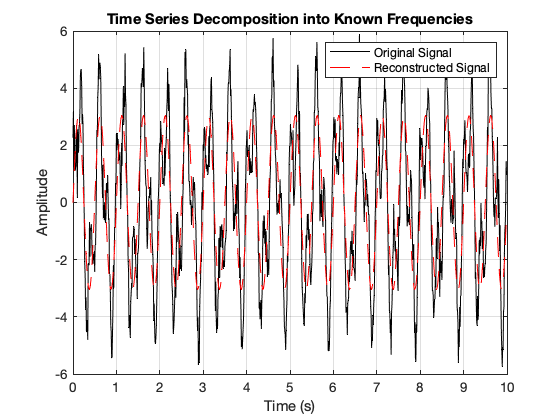

In [29]:
fs = 100; % Sampling frequency (Hz)
t = 0:1/fs:10-1/fs; % Time vector (10 seconds)
y = 3*sin(2*pi*2*t) + 2*cos(2*pi*5*t) + 0.5*randn(size(t)); % Signal with noise

frequencies = [2]; % Known frequencies (Hz)

X = []; % Design matrix
for f = frequencies
    X = [X, cos(2*pi*f*t)', sin(2*pi*f*t)'];
end

coeffs = X \ y'; % Solve using least squares
amplitudes = sqrt(coeffs(1:2:end).^2 + coeffs(2:2:end).^2);
phases = atan2(-coeffs(2:2:end), coeffs(1:2:end));

y_reconstructed = X * coeffs;

figure;
plot(t, y, 'k', 'DisplayName', 'Original Signal'); hold on;
plot(t, y_reconstructed, 'r--', 'DisplayName', 'Reconstructed Signal');
xlabel('Time (s)');
ylabel('Amplitude');
legend;
title('Time Series Decomposition into Known Frequencies');
grid on;

# Testing the code

Significant Wave Height Hs: 1.1202 meters
Dominant Frequency: 0.10742 Hz
Peak Period: 9.3091 seconds


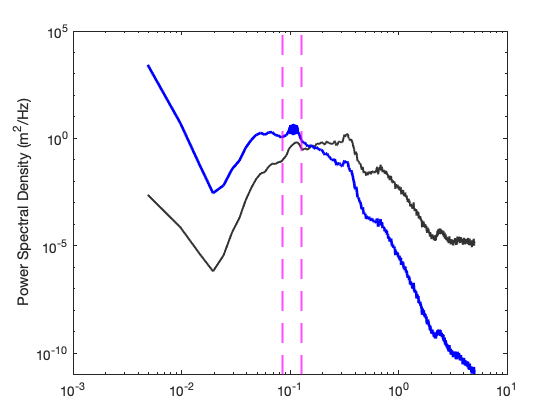

In [30]:
ac = glider_data.ACC_0_ < -7.5;
data = glider_data.ACC_0_(ac);

[P_eta, k,a_z_filtered, H_s, f_peak, T_peak, t] = stat_wave_1D(data, 10, 0.05);

# Now buoy


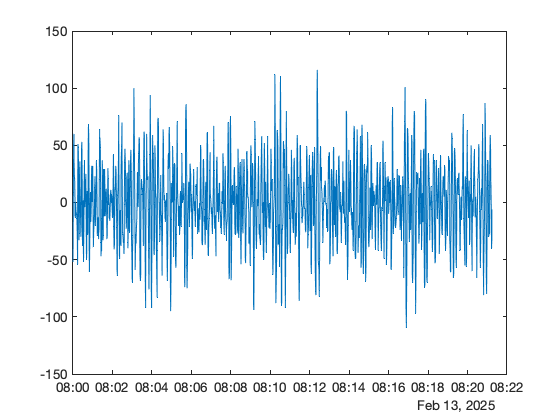

In [31]:
buoy = readtable('buoy_data.txt');
time  = datetime(num2str(buoy.time), 'InputFormat', 'yyyyMMddHHmmss');
plot(time, buoy.V)

In [32]:
[B,kb]=fast_psd(buoy.V./100,2^9,1);




freq_range_b =

    0.0734    0.1102

Significant Wave Height Hs: 0.98509 meters
Dominant Frequency: 0.091797 Hz
Peak Period: 10.8936 seconds


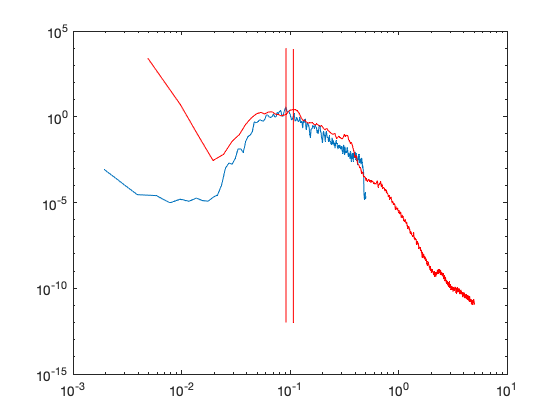

In [33]:
% Step 1: Find the dominant frequency (peak frequency)
[~, idx_peak] = max(B);  % Find index of maximum displacement spectrum
f_peak_b = kb(idx_peak);  % Dominant frequency

% Step 2: Define a frequency range around the peak (e.g., ±20% of the peak frequency)
freq_range_b = [f_peak_b * 0.8, f_peak_b * 1.2]  % Range around the peak frequency

% Step 3: Find indices for the frequency range
freq_indices_b = find(kb >= freq_range_b(1) & kb <= freq_range_b(2));

% Step 4: Integrate over the selected frequency range (S_eta over the range)
m0b = trapz(kb(freq_indices_b), B(freq_indices_b));  % Numerical integration over the selected range

% Step 5: Calculate Significant Wave Height (H_s)
H_s_b = 4 * sqrt(m0b);

% Display result
disp(['Significant Wave Height Hs: ', num2str(H_s_b), ' meters']);
T_peak_b = 1 / f_peak_b;

% Display results
disp(['Dominant Frequency: ', num2str(f_peak_b), ' Hz']);
disp(['Peak Period: ', num2str(T_peak_b), ' seconds']);

loglog(kb,B); hold on
loglog(k, P_eta, 'r'); hold on
 line([f_peak f_peak], ylim', 'color', 'r') % peak frequency
 line([f_peak_b f_peak_b], ylim', 'color', 'r') % peak frequency

# Trying out directional

We are going to try three methods to (1) understand what the glider is doing
(2) which option is closer to real life

* Cross-Spectra
* MLM Maximum Likelihood Methods
* MEM Maximum Entropy method



## Cross-Spectra

In [34]:
% prepering the data

ac = glider_data.ACC_0_ < -7.5;

% aceleration (m/s^2)
glider.heave = glider_data.ACC_0_(ac); % heave (x) up-down motion
glider.surge = glider_data.ACC_1_(ac); % surge (y) forwrd-backward motion
glider.sway = glider_data.ACC_2_(ac); % sway  (z) Side-to-side motion

% Angular velocity (rad/s)
glider.PQR_0 = glider_data.PQR_0_(ac); 
glider.PQR_1 = glider_data.PQR_1_(ac);
glider.PQR_2 = glider_data.PQR_2_(ac);

% Euler angles (deg)
glider.yaw = glider_data.Euler_0_(ac);  % Yaw
glider.pitch = glider_data.Euler_1_(ac); % Pitch
glider.roll = glider_data.Euler_2_(ac); % Roll


We need to convert deg to radients of the euler angles. Need to make sure this is correct



In [35]:
% Convert pitch and roll from degrees to radians
glider.pitch_rad = deg2rad(glider.pitch);
glider.roll_rad  = deg2rad(glider.roll);

In [36]:
% Load or simulate motion data
fs = 10; % Sampling frequency in Hz
fc = 0.05; % Cutoff frequency in Hz (remove drift below this)
order = 4; % Filter order
Nfft = 2^10; % Number of FFT points 

% Choose a window size and overlap for mscohere
window = hanning(Nfft);
noverlap = Nfft/2; % 50% overlap


% Estimate PSD for all glider variables
fields = fieldnames(glider);
PSD = struct();
data_p = struct();

for i = 1:length(fields)
    var_name = fields{i};
    
    % High-pass filter
    [data_p.(var_name)] = quick_high_pass_filter(glider.(var_name), fs, fc, order); % Removing low frequency noise
    
    % Compute Power Spectral Density (PSD)
    [PSD.(var_name), k_psd] = fast_psd(data_p.(var_name), Nfft, fs);  % Similar to matlab pwelch (data_p.(var_name), hamming(Nfft), Nfft/2, Nfft, fs);
end






In [37]:
% Compute Cross-Spectral Density (CSD)
[CSD_hp, k_csd] = cpsd(data_p.heave, data_p.pitch_rad, window, noverlap, Nfft, fs); % Heave-Pitch
[CSD_hr, ~] = cpsd(data_p.heave, data_p.roll_rad, window, noverlap, Nfft, fs); % Heave-roll
[CSD_pr, ~] = cpsd(data_p.pitch, data_p.roll_rad, window, noverlap, Nfft, fs); % Heave-roll

% Compute the magnitude-squared coherence as well
[Coherence_hp, k_coh] = mscohere(data_p.heave, data_p.pitch_rad, window, noverlap, Nfft, fs);
[Coherence_hr, ~]     = mscohere(data_p.heave, data_p.roll_rad, window, noverlap, Nfft, fs);


[Ssp, ~] = cpsd(data_p.surge, data_p.pitch_rad, [], [], Nfft, fs); % surge-Pitch
[Sar, ~] = cpsd(data_p.sway, data_p.roll_rad, [], [], Nfft, fs); % sway-Roll


In [38]:
loglog(k,PSD.heave, 'k'); hold on; hold on
loglog(k,PSD.pitch, 'b'); hold on
loglog(k,PSD.roll, 'g'); hold on

Error using loglog
Specify the coordinates as vectors or matrices of the same size, or as a vector and a matrix that share the same length in at least one dimension.



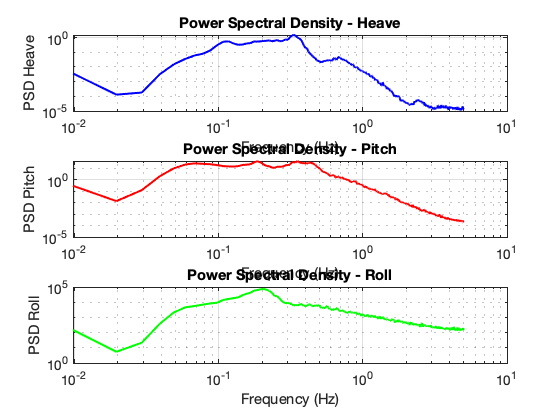

In [39]:
figure;
subplot(3,1,1);
loglog(k_psd, PSD.heave, 'b', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('PSD Heave');
title('Power Spectral Density - Heave'); grid on;

subplot(3,1,2);
loglog(k_psd, PSD.pitch, 'r', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('PSD Pitch');
title('Power Spectral Density - Pitch'); grid on;

subplot(3,1,3);
loglog(k_psd, PSD.roll, 'g', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('PSD Roll');
title('Power Spectral Density - Roll'); grid on;

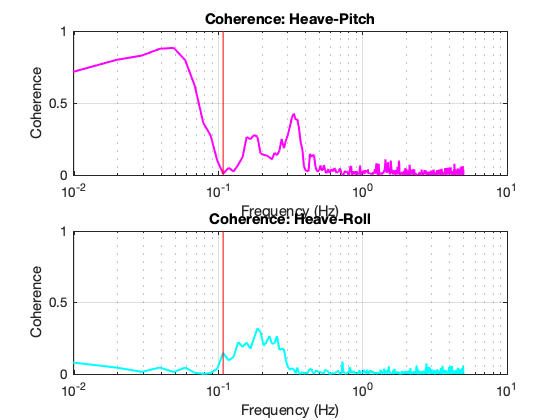

In [40]:
% Plot the Coherence between Heave-Pitch and Heave-Roll
figure;
subplot(2,1,1);
semilogx(k_coh, Coherence_hp, 'm', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('Coherence');
title('Coherence: Heave-Pitch'); grid on;
ylim([0 1]);
line([f_peak f_peak], ylim', 'color', 'r') % peak frequency

subplot(2,1,2);
semilogx(k_coh, Coherence_hr, 'c', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('Coherence');
title('Coherence: Heave-Roll'); grid on;
ylim([0 1]);

line([f_peak f_peak], ylim', 'color', 'r') % peak frequency



In [41]:
% Extract and plot the cross-spectral phase
phase_hp = angle(CSD_hp) * (180/pi);  % Convert phase to degrees
phase_hr = angle(CSD_hr) * (180/pi);

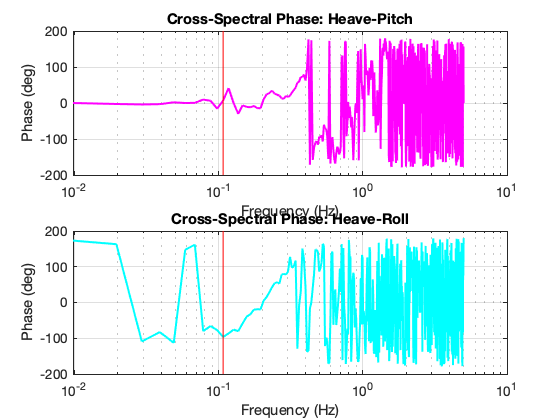

In [42]:
figure;
subplot(2,1,1);
semilogx(k_csd, phase_hp, 'm', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('Phase (deg)');
title('Cross-Spectral Phase: Heave-Pitch'); grid on;
line([f_peak f_peak], ylim', 'color', 'r') % peak frequency

subplot(2,1,2);
semilogx(k_csd, phase_hr, 'c', 'LineWidth',1.5);
xlabel('Frequency (Hz)'); ylabel('Phase (deg)');
title('Cross-Spectral Phase: Heave-Roll'); grid on;
line([f_peak f_peak], ylim', 'color', 'r') % peak frequency

# MLM

In [43]:


nFreq = length(k_psd); % Number of frequency bins
S_meas = zeros(3,3,nFreq);  % Initialize

% S_meas(:,:,k) is the full cross-spectral matrix at freq(k).÷
for k = 1:nFreq
    % Diagonal entries (auto-spectra)
    S_meas(1,1,k) = PSD.heave(k);
    S_meas(2,2,k) = PSD.pitch(k);
    S_meas(3,3,k) = PSD.roll(k);
    
    % Off-diagonal entries (cross-spectra)
    % By definition, Sxy = conj(Syx), etc.
    S_meas(1,2,k) = CSD_hp(k); 
    S_meas(2,1,k) = conj(CSD_hp(k));
    
    S_meas(1,3,k) = CSD_hr(k);
    S_meas(3,1,k) = conj(CSD_hr(k));
    
    S_meas(2,3,k) = CSD_pr(k);
    S_meas(3,2,k) = conj(CSD_pr(k));
end

% % 4. (Optional) Inspect one frequency bin
% kPeak = find(PSD.heave == max(PSD.heave)); % or whichever peak you want
% disp('Cross-spectral matrix at peak frequency:');
% disp(S_meas(:,:,kPeak));
% disp(['Frequency = ', num2str(k_psd(kPeak)), ' Hz']);


In [44]:
% Define directional grid (in degrees)
theta = linspace(0, 360, 73);   % 73 points gives 0:5:360 deg (duplicate 0 and 360)
theta = theta(1:end-1);         % Remove duplicate at 360° so we have 72 directions
N_dir = length(theta);          % Number of directional bins
DeltaTheta = 360 / N_dir;       % Angular bin width (in degrees)

In [45]:

% Define simple RAO models (replace these with your actual RAOs if available)
RAO_heave = ones(1, N_dir);          % Heave: assumed uniform response
RAO_pitch = ones(1, N_dir);%;cosd(theta);             % Pitch: simple cosine model
RAO_roll  = ones(1, N_dir);%sind(theta);             % Roll: simple sine model

In [46]:
% Initial guess: uniform directional distribution
D0 = ones(N_dir,1) / N_dir;  % Column vector, sum(D0)*DeltaTheta should be 1 approximately

% Set constraints: D >= 0 and the distribution must be normalized:
% That is, sum(D)*DeltaTheta = 1.
Aeq = ones(1, N_dir) * DeltaTheta;  % Equality constraint matrix
beq = 1;                            % Equality constraint value
lb = zeros(N_dir,1);                % Lower bound: D >= 0
ub = ones(N_dir,1);                 % Upper bound (can be high)

options = optimoptions('fmincon', 'Display', 'iter', 'Algorithm', 'sqp');

In [47]:
n_fpeak = find(k_psd == f_peak) % Find the index of the peak frequency

S_meas_k = S_meas(:,:,n_fpeak); 
S1D = PSD.heave(n_fpeak) % Extract the 1D spectrum at the peak frequency

% % Wrap the cost function in an anonymous function for fmincon
costFun = @(D) costFunction(D, S_meas_k, S1D, RAO_heave, RAO_pitch, RAO_roll, DeltaTheta);

% % Run the optimization
[D_opt, J_opt] = fmincon(costFun, D0, [], [], Aeq, beq, lb, ub, [], options);



n_fpeak =

    11


S1D =

    0.5235

 Iter  Func-count            Fval   Feasibility   Step Length       Norm of   First-order  
                                                                       step    optimality
    0          73    1.952603e+08     4.000e+00     1.000e+00     0.000e+00     7.314e+04  
    1         146    1.953188e+08     9.548e-15     1.000e+00     9.428e-02     1.020e+02  
    2         219    1.953188e+08     2.887e-15     1.000e+00     2.250e-16     1.455e-11  

Local minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.



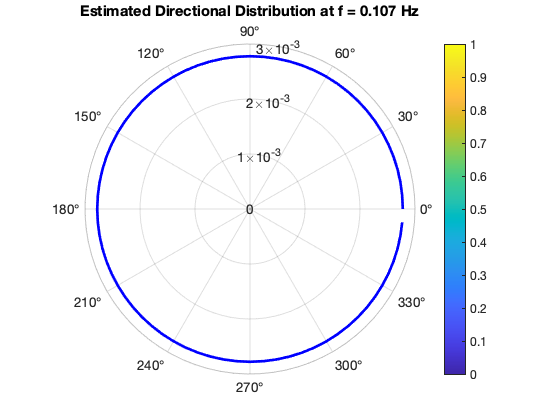

In [48]:
% Normalize the solution (if not already)
D_opt = D_opt / (sum(D_opt)*DeltaTheta);

% Plot the estimated directional distribution
figure;
polarplot(deg2rad(theta), D_opt, 'b-', 'LineWidth', 2);
title(sprintf('Estimated Directional Distribution at f = %.3f Hz', k_psd(n_fpeak)));
colorbar


In [49]:
options = optimoptions('fmincon', 'Display', 'off', 'Algorithm', 'sqp');

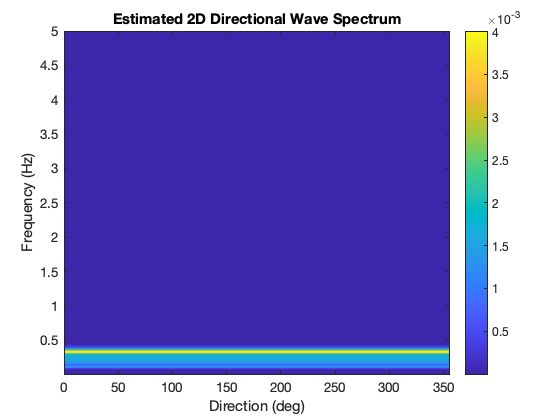

In [50]:
% Preallocate directional distribution matrix: one row per frequency, one column per direction
D_all = zeros(nFreq, N_dir);

for k = 1:nFreq
    % Use frequency bin k:
    S_meas_k = S_meas(:,:,k);
    S1D = PSD.heave(k);  % or your computed 1D spectrum
    
    % You can optionally skip frequencies with very low energy.
    if S1D < 1e-10
        D_all(k,:) = zeros(1, N_dir);
        continue;
    end
    
    % Run optimization for this frequency bin
    costFun = @(D) costFunction(D, S_meas_k, S1D, RAO_heave, RAO_pitch, RAO_roll, DeltaTheta);
    [D_opt, ~] = fmincon(costFun, D0, [], [], Aeq, beq, lb, ub, [], options);
    D_opt = D_opt / (sum(D_opt)*DeltaTheta);  % Normalize
    
    D_all(k,:) = D_opt';
end

% Now, D_all is an [nFreq x N_dir] directional distribution matrix.
% You can combine this with your 1D spectrum to form the 2D directional wave spectrum:
S_2D = zeros(nFreq, N_dir);
for k = 1:nFreq
    S_2D(k,:) = PSD.heave(k) * D_all(k,:);  % Scale by the 1D spectrum at frequency k
end

% Plot the 2D spectrum as a contour plot:
figure;
[Theta, FreqGrid] = meshgrid(theta, k_psd);
contourf(Theta, FreqGrid, S_2D, 20, 'LineStyle', 'none');
xlabel('Direction (deg)');
ylabel('Frequency (Hz)');
title('Estimated 2D Directional Wave Spectrum');
colorbar;


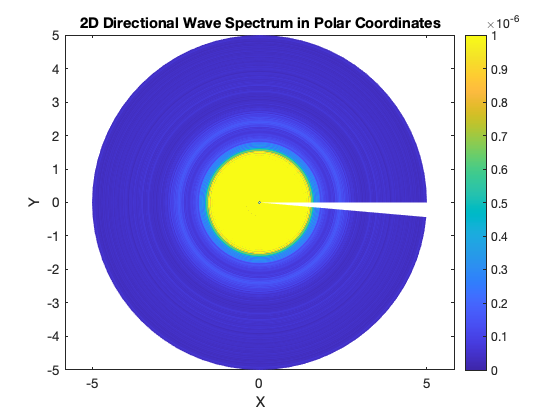

In [51]:
[Theta, FreqGrid] = meshgrid(theta, k_psd);  % Theta in degrees, FreqGrid in Hz

% Convert polar coordinates (frequency, direction) to Cartesian coordinates for plotting:
X = FreqGrid .* cosd(Theta);
Y = FreqGrid .* sind(Theta);

% Plot using pcolor (or contourf) to create a smooth polar contour plot:
figure;
pcolor(X, Y, S_2D);
shading interp;      % smooth color transitions
colorbar;
xlabel('X'); ylabel('Y');
title('2D Directional Wave Spectrum in Polar Coordinates');
axis equal;        % ensures correct aspect ratio
caxis([0 .000001]); % Set color axis limits

# REading Waves


From the NOA buoy


In [ ]:
clear all
data = readtable('Buoy_data_realtime.txt');
buoy.DateTime = datetime(data.Var1, data.Var2, data.Var3, data.Var4, data.Var5, 0);
plot(buoy.DateTime)

In [ ]:
url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/098p1_rt.nc?waveTime[0:1:53737],waveTimeBounds[0:1:53737][0:1:1],waveFlagPrimary[0:1:53737],waveHs[0:1:53737],waveTp[0:1:53737],waveTa[0:1:53737],waveDp[0:1:53737],wavePeakPSD[0:1:53737],waveTz[0:1:53737],waveFrequency[0:1:63],waveFrequencyBounds[0:1:63][0:1:1],waveFrequencyFlagPrimary[0:1:63],waveBandwidth[0:1:63],waveEnergyDensity[0:1:0][0:1:0],waveMeanDirection[0:1:0][0:1:0],waveA1Value[0:1:0][0:1:0],waveB2Value[0:1:0][0:1:0],waveSpread[0:1:0][0:1:0],waveM2Value[0:1:0][0:1:0],waveN2Value[0:1:0][0:1:0],sstTime[0:1:53737],sstSeaSurfaceTemperature[0:1:53737],gpsTime[0:1:53737],gpsLatitude[0:1:53737],gpsLongitude[0:1:53737],dwrTime[0:1:53737],dwrZAccelerometerOffset[0:1:53737],dwrXAccelerometerOffset[0:1:53737],dwrYAccelerometerOffset[0:1:53737],dwrOrientation[0:1:53737],dwrInclination[0:1:53737],metaStationName,metaDeployLatitude,metaDeployLongitude,metaWaterDepth,metaDeclination,metaGridMapping';

% ncdisp(url);

NOAA.wTime = datetime(ncread(url, 'waveTime'), 'ConvertFrom','posixtime');
NOAA.wTimeBounds = datetime((ncread(url, 'waveTimeBounds')), 'ConvertFrom', 'posixtime');
NOAA.wHs = ncread(url, 'waveHs');

NOAA.wTa = ncread(url, 'waveTa'); % average wave period
NOAA.wDp = ncread(url, 'waveDp'); 
NOAA.wP_PSD = ncread(url, 'wavePeakPSD'); %peak wave power spectral density 
NOAA.wTp = ncread(url, 'waveTp');

% Now this would be frequency
NOAA.wf = ncread(url, 'waveFrequency');
NOAA.wf_Band = ncread(url, 'waveBandwidth');
NOAA.wf_E = ncread(url, 'waveEnergyDensity');
NOAA.wf_MeanDir = ncread(url,'waveMeanDirection');

% Temperature sensor
NOAA.sstTime = datetime(ncread(url, 'sstTime'), "ConvertFrom","posixtime");
NOAA.sst = ncread(url,'sstSeaSurfaceTemperature');

% GPS sensor
NOAA.gpsTime = datetime(ncread(url, 'gpsTime'), "ConvertFrom","posixtime");
NOAA.gpsLat = ncread(url, 'gpsLatitude');
NOAA.gpsLon = ncread(url, 'gpsLongitude');

% dwr sensor
NOAA.dwrTime = datetime(ncread(url, 'dwrTime'), "ConvertFrom", "posixtime");
NOAA.dwrZA = ncread(url, 'dwrZAccelerometerOffset');
NOAA.dwrXA = ncread(url, 'dwrXAccelerometerOffset');
NOAA.dwrYA = ncread(url, 'dwrYAccelerometerOffset');
NOAA.dwrOr = ncread(url, 'dwrOrientation');
NOAA.dwrIn = ncread(url, 'dwrInclination');



In [ ]:

date1 = datetime(2025,02,13,0,0,0);
date2 = datetime(2025,02,14, 0 ,0 ,0);
plot(NOAA.sstTime, NOAA.sst)

ab = NOAA.sstTime < date2 & NOAA.sstTime > date1;

hold on
plot(NOAA.sstTime(ab), NOAA.sst(ab), 'xr');
xlim([datetime(2025, 02,12), datetime(2025,02,15)])
title('temperature')

In [ ]:
plot(NOAA.wTime, NOAA.wHs* 3.28084)
ab = NOAA.wTime < date2 & NOAA.wTime > date1;
hold on
plot(NOAA.wTime(ab), NOAA.wHs(ab) * 3.28084, 'r')
xlim([datetime(2025, 02,22), datetime(2025,02,28)])